In [2]:
# additional libraries: matplotlib, seaborn

import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
load_dotenv(override=True)
engine = create_engine(os.environ.get("ALCHEMY_DATABASE_URL"), connect_args={'connect_timeout': 600})

## Query Function


In [5]:
#function definition for running queries
def run_query(query):
    with engine.connect() as connection:
        return pd.read_sql(query, connection)

## Roll Up


Roll Up Query Result
    year  total_games
0   1997            2
1   1998            1
2   1999            3
3   2000            2
4   2001            4
5   2002            1
6   2003            3
7   2004            7
8   2005            7
9   2006           69
10  2007          109
11  2008          176
12  2009          343
13  2010          309
14  2011          286
15  2012          357
16  2013          492
17  2014         1634
18  2015         2693
19  2016         4416
20  2017         6334
21  2018         8183
22  2019         7827
23  2020         9647
24  2021        12392
25  2022        13989
26  2023        15542
27  2024        12580
28  2025            2


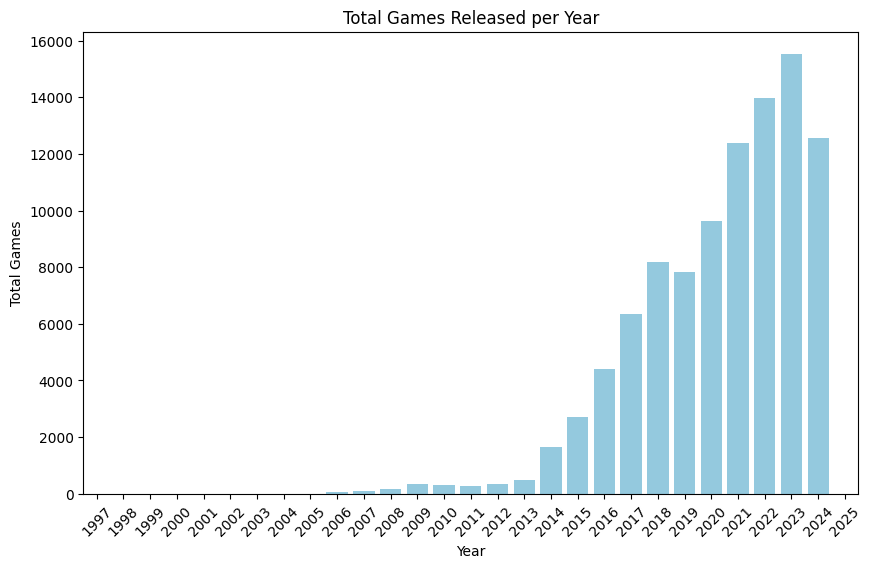

In [6]:
# Roll Up
roll_up_query = """
SELECT D.year, COUNT(G.id) AS total_games 
FROM game_fact_table AS G 
JOIN dimDate D ON G.releaseDate = D.date 
GROUP BY D.year;
"""
roll_up_df = run_query(roll_up_query)
print("Roll Up Query Result")
print(roll_up_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=roll_up_df, x='year', y='total_games', color='skyblue')
plt.title("Total Games Released per Year")
plt.xlabel("Year")
plt.ylabel("Total Games")
plt.xticks(rotation=45)
plt.show()

View number of games released per year.


## Dice


Dice Query Result
                  name  tag count
0               Action       4724
1                Indie       4275
2          Multiplayer       3825
3               Casual       2718
4                  PvP       2434
..                 ...        ...
430              Rugby          1
431  Dynamic Narration          1
432             Reboot          1
433     Boomer Shooter          1
434            Mahjong          1

[435 rows x 2 columns]


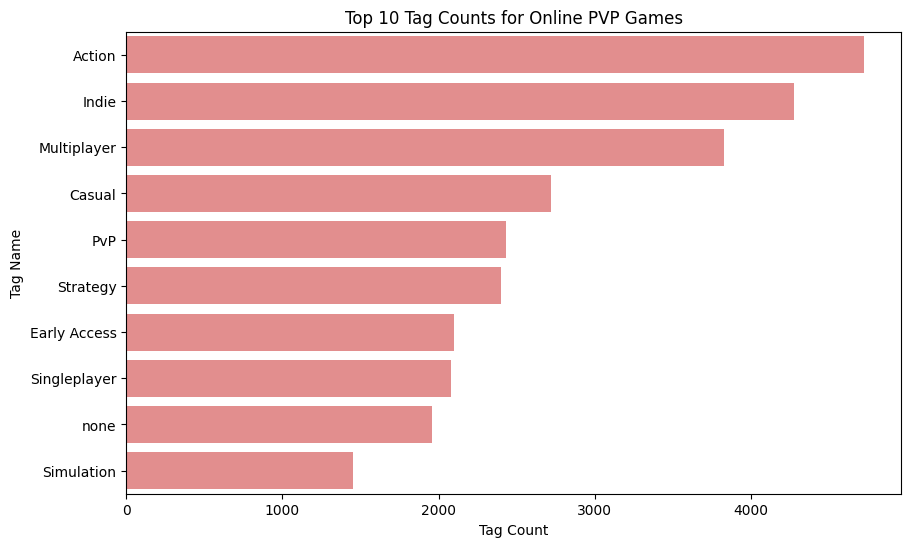

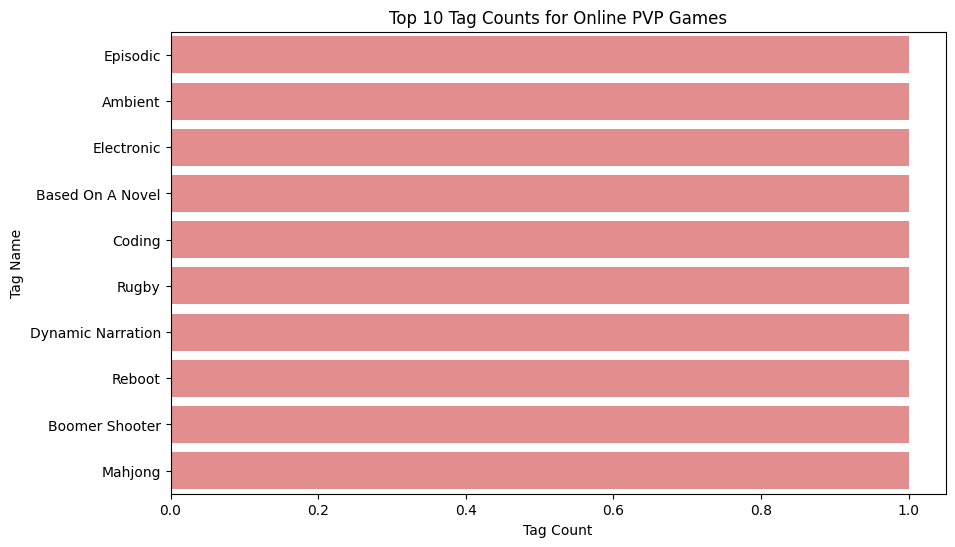

In [11]:
# Dice
dice_query = """
SELECT t.name, COUNT(t.name) AS 'tag count'
FROM game_fact_table g
LEFT JOIN dimcategory dc ON g.dimCategoryId = dc.dimCategoryId
LEFT JOIN category c on dc.dimCategoryId = c.groupId
LEFT JOIN dimtag dt ON dt.dimTagId = g.dimTagId
LEFT JOIN tag t ON dt.dimTagId = t.groupId
WHERE c.name = 'Online PVP' 
GROUP BY t.name
ORDER BY COUNT(t.name) DESC;
"""
dice_df = run_query(dice_query)
print("Dice Query Result")
print(dice_df)

top_n = 10
top_dice_df = dice_df.head(top_n)
bottom_dice_df = dice_df.tail(top_n)

#displays top 10 for readability
plt.figure(figsize=(10, 6))
sns.barplot(data=top_dice_df, y='name', x='tag count', color='lightcoral')
plt.title("Top 10 Tag Counts for Online PVP Games")
plt.xlabel("Tag Count")
plt.ylabel("Tag Name")
plt.show()

#displays bottom 10
plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_dice_df, y='name', x='tag count', color='lightcoral')
plt.title("Top 10 Tag Counts for Online PVP Games")
plt.xlabel("Tag Count")
plt.ylabel("Tag Name")
plt.show()


View the most common tags of the game category "Online PVP"


## Slice


Slice Query Result
     game  price developer
0  Dota 2    0.0     Valve


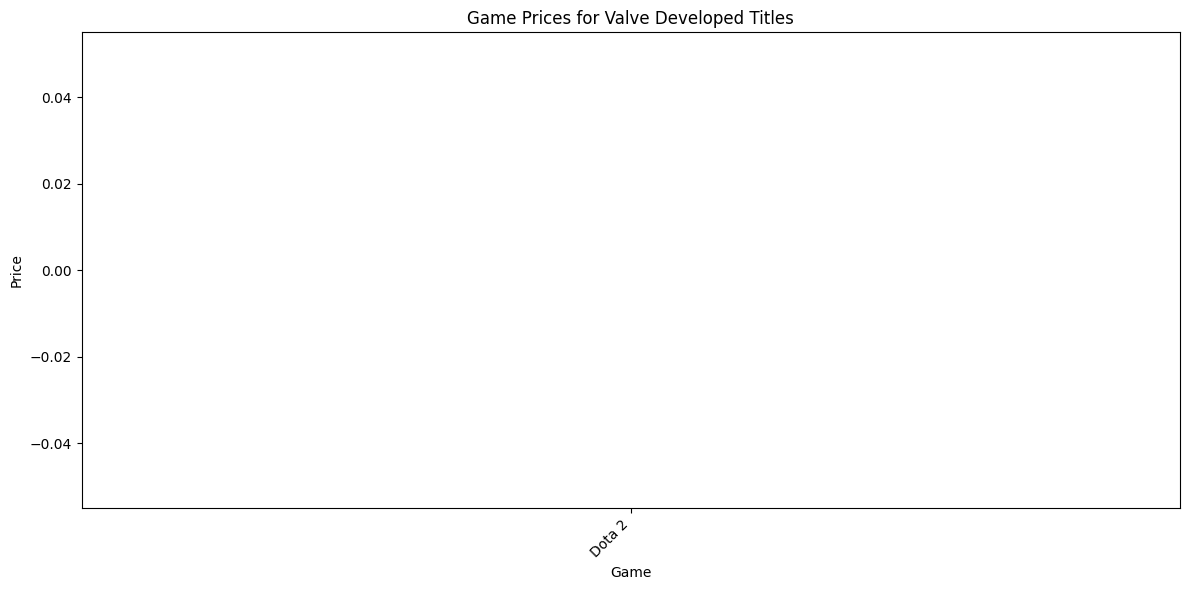

In [14]:
# Slice

drill_down_query = """
SELECT g.name AS game, g.price, de.name AS developer
FROM Game_Fact_Table AS g
LEFT JOIN dimDeveloper dd ON dd.dimDeveloperId = g.dimDeveloperId
LEFT JOIN developer de ON de.groupId = dd.dimDeveloperId
WHERE de.name = 'Valve' AND G.reviews !=''
ORDER BY game;
"""

drill_down_df = run_query(drill_down_query)
print("Slice Query Result")
print(drill_down_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=drill_down_df, x='game', y='price', color='steelblue')
plt.title("Game Prices for Valve Developed Titles")
plt.xlabel("Game")
plt.ylabel("Price")
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

View games developed by Valve that were reviewed critically by game journals or has reviews present.


## Drill Down


Drill Down Query Result
                                                   game releaseDate   price  \
0                                       Hogwarts Legacy  2023-02-10   59.99   
1                                    Sons Of The Forest  2023-02-23   29.99   
2                                       Resident Evil 4  2023-03-23   59.99   
3                               Wo Long: Fallen Dynasty  2023-03-03   59.99   
4                                      Hero's Adventure  2023-03-07   15.83   
5                                   Company of Heroes 3  2023-02-23   59.99   
6                                            Dead Space  2023-01-27   59.99   
7                                          WILD HEARTS™  2023-02-16   69.99   
8                                          Atomic Heart  2023-02-20   59.99   
9                                The Last of Us™ Part I  2023-03-28   59.99   
10                                 OCTOPATH TRAVELER II  2023-02-24   59.99   
11                          

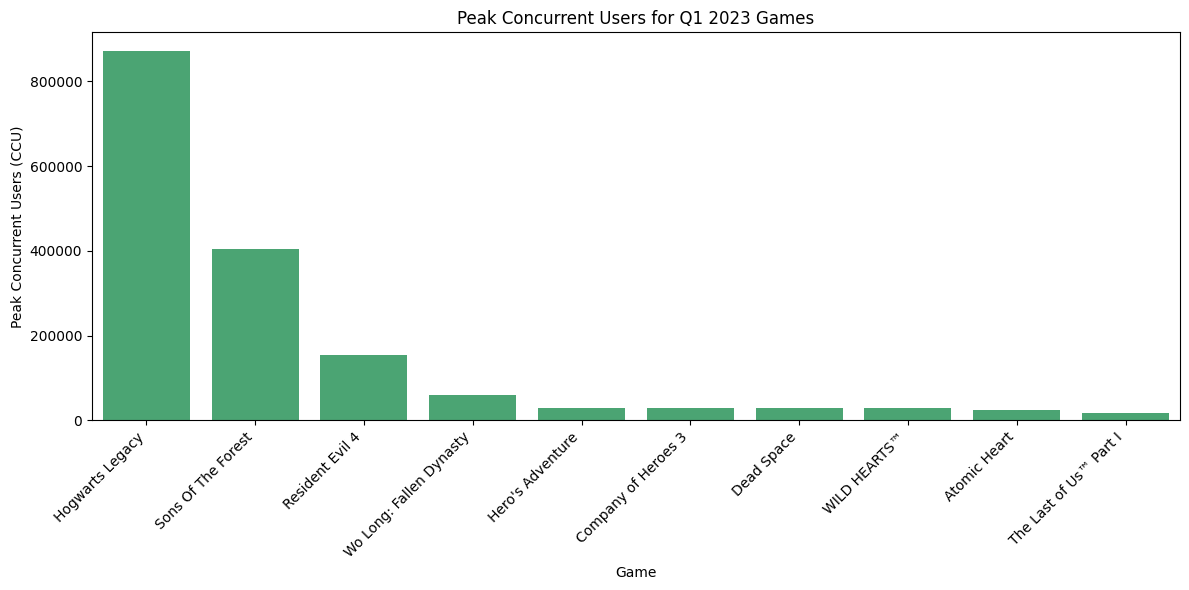

In [16]:
# Drill Down
slice_query = """
SELECT name AS game, releaseDate, price, quarter, estimatedOwners, peakCCU 
FROM game_fact_table g
LEFT JOIN dimDate ddt ON ddt.date = g.releaseDate
WHERE ddt.quarter = 1 AND ddt.year = 2023 AND price > 0
ORDER BY peakCCU DESC;
"""
slice_df = run_query(slice_query)
print("Drill Down Query Result")
print(slice_df)

top_n = 10
top_drill_down_df = slice_df.head(top_n)

#displays top 10 for readability
plt.figure(figsize=(12, 6))
sns.barplot(data=top_drill_down_df, x='game', y='peakCCU', color='mediumseagreen')
plt.title("Peak Concurrent Users for Q1 2023 Games")
plt.xlabel("Game")
plt.ylabel("Peak Concurrent Users (CCU)")
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

View games released on Q1 of 2023 that aren't free and their estimated owners ordered by peakCCU.
